In [106]:
from tensorflow.keras import initializers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Softmax, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras import utils
import tensorflow.keras.backend as K
import numpy as np
from sklearn.model_selection import train_test_split
# this helps split training data randomly

In [107]:
def my_init(shape, dtype=np.float32):
    # keep the name as convention. This is important when we pass variable by name
    # eg: my_init(shape=(2,2),dtype=np.float32) 
    return K.random_normal(shape, dtype=dtype)

In [108]:
simpleForward = Sequential([
    Flatten(input_shape=(28,28)),
    # input_shape can be ignored (it can be inferred)
    Dense(64, activation='relu',input_shape=(784,),name='layer1'),
    Dropout(0.4),
    Dense(16,activation='relu',kernel_initializer='glorot_uniform',name='layer2'),
    # the default kernel_initializer (way of initializing kernel weights) is glorot_uniform
    # glorot draws values with || < sqrt(6/(u+v) where u is the number of previous layer, 
    # v is the number of next layer. We clamp down the value so that the value put through to the 
    # next layer is about the same in || size as the value put in from the previous layer.
    # Of course, whether the two values match depends also on the activation function. Expectedly, 
    # a relu is best with a clamper of 1/u where u is the size of the previous layer.
    Dense(16,activation='relu',kernel_initializer='he_uniform',name='layer3'),
    Dropout(0.05),
    # he_uniform clamps the value below sqrt(6/u)
    Dense(16,activation='relu',kernel_initializer=initializers.RandomUniform(minval=-0.5,maxval=0.5)),
    # RandomUniform of course clamps it between the specified values. 
    # If we use text shortcut 'random_uniform', the default is -0.05 to 0.05
    Dense(16, activation='relu', kernel_initializer=initializers.Orthogonal()),
    Dropout(0.05),
    # Orthogonal creates a orthogonal matrix of weights. It only works if the weights are 2D.
    Dense(16,activation='relu',kernel_initializer=my_init),
    # Of course we can also use our initializer as long as it's built with keras backend.
    Dropout(0.05),
    # All the above initializers can be set to normal instead of uniform. 
    # Normal just means it's a normal distribution. The clampers will become the std.
    Dense(16,activation='relu',kernel_initializer=initializers.HeNormal(seed=None)),
    # he_uniform makes the std = sqrt(2/u) (constant adjusted because it's the std, not the outer bound).
    # Another way to view it is variance = 2/u. The reason for its exact form is more involved.
    Dense(16,activation='relu',kernel_initializer=initializers.RandomNormal(mean=0,stddev=1/16)),
    # Again, RandomNormal is self-customizing a normal distribution
    Dense(16,activation='relu',kernel_initializer='glorot_normal')
    # Same clamping as glorot uniform (applied to std)
])
# the constructor takes in a list of layers which can of course be added later on. 

In [109]:
simpleForward.add(Dense(16,activation='relu',bias_initializer=initializers.Constant(value=0.5)))
# Bias has its separate initializer. Bias is by default = 0. A constant initializer namely gives a constant
simpleForward.add(Dense(16,activation='relu',bias_initializer='zeros'))
simpleForward.add(Dropout(0.05))
simpleForward.add(Dense(16,activation='elu'))
# Elu activation is one of the leaky relu (anything ending with 'lu' is a linear unit). Elu attaches an exponential function before the linear function. The exponential function has a small positive slop 
# which helps ease the neuron-death problem. Also, the negative value of the exponential function 
# brings the average activation value closer to 0, which is better because the gradient descent is 
# closer to natural gradient (the theoretical optimal gradient descent method). 
simpleForward.add(Dense(16,activation='selu'))
# scaled elu. Basically we scale both the linear and exponential part by some factor 
# to control the rate of activation.
simpleForward.add(Dropout(0.05))
simpleForward.add(Dense(16,activation='tanh'))
# tanh is pretty much sigmoid shifted downward and stretched so that it ranges from -1 to 1. 
# Again better than sigmoid because the average is 0.
simpleForward.add(Dense(10,name='layer4'))
# the default activation function is linear function (itself, no nonlinearity)
simpleForward.add(Softmax())
# softmax can be written as a layer all by itself. In fact, it makes intuitive sense to write it as a separate layer, since what it really does is taking values from the previous layer and outputing probabilities according to normal distributions. 
simpleForward.summary()



Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
layer1 (Dense)               (None, 64)                50240     
_________________________________________________________________
dropout_16 (Dropout)         (None, 64)                0         
_________________________________________________________________
layer2 (Dense)               (None, 16)                1040      
_________________________________________________________________
layer3 (Dense)               (None, 16)                272       
_________________________________________________________________
dropout_17 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 16)               

In [110]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D


In [111]:
simpleCovnet = Sequential([
    Conv2D(16,(3,3),strides=(1,1),activation='relu',input_shape=(28,28,1)),
    # strides control the stride in the two directions
    BatchNormalization(axis=-1, momentum=0.9),
    # Batch normalization, momentum refers to the how much does the weight of the previous batches weight
    #  (used in evaluation or prediction mode; 
    # in training, we only take mean and std over the current batch). 
    # Axis is the axis for which we normalize. All other axis except this chosen axis 
    # (or this set of chosen axis) will be collapsed (mean, std will be taken in their direction).
    # This axis or set of axis is the only axis across which we don't take the mean and std so that each
    # element of the axis remain independent from each other. For sure it should usually be 
    # the feature axis. For a Conv2D layer that means our mean and std for 
    # each feature is taken independently across all samples in this batch 
    # and also across all positions/locations on the 2D plane of vision
    MaxPooling2D((2,2)),
    # maxpooling automatically assumes non-overlap, so the strides is set so that there's no overlap
    Conv2D(16,(2,2),padding='valid',activation='relu'),
    # valid padding = no padding (the size of output will be reduced as predicted by kernel size)
    BatchNormalization(beta_initializer=initializers.RandomNormal(mean=1,stddev=0.4)),
    # beta is the desired mean after the normalization (so it also serves functionality of the bias term)
    MaxPooling2D((2,2)),
    Conv2D(32,(2,2),padding='SAME',activation='relu', data_format='channels_last'),
    # same padding ensures output dimension is the same as input
    # data_format indicates if channels come first in the output dimensions or last
    BatchNormalization(gamma_initializer=initializers.Constant(value=1)),
    # gamma is the desired std after the normalization

    Flatten(),
    Dropout(0.5),
    Dense(16, activation='elu', kernel_regularizer=regularizers.L1(0.005)),
    Dropout(0.3),
    Dense(16, activation='elu', kernel_regularizer=regularizers.L2(0.01)),
    Dense(16, activation='selu', kernel_regularizer = regularizers.L1L2(l1=0.01,l2=0.02)),
    Dense(10,activation='softmax')
    # linear equals no activation (it's the default)
])
simpleCovnet.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
batch_normalization_6 (Batch (None, 26, 26, 16)        64        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 12, 12, 16)        1040      
_________________________________________________________________
batch_normalization_7 (Batch (None, 12, 12, 16)        64        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 16)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 6, 6, 32)         

In [112]:
simpleForward.compile(
    optimizer='sgd', # adam, rmsprop (default), adadelta 
    loss='sparse_categorical_crossentropy', 
    # (sparse_)categorical_crossentropy, binary_crossentropy, mean_square_error (mse)
    # sparse_categorical_crossentropy is used when the target labels are encoded as integers 
    # instead of one-hot encoding (it's no different from categorical_crossentropy)
    metrics=['acc','sparse_categorical_accuracy'] 
    # accuracy (acc), binary_accuracy, categorical_accuracy, 
    # mean_absolute_error (mae), mean_absolute_percentage_error (mape)
)

In [113]:
print(simpleForward.optimizer)
print(simpleForward.loss)
print(simpleForward.metrics)

sparse_categorical_crossentropy
[]


In [83]:
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics

In [84]:
def custom_metric(y_true, y_pred):
    return K.mean(K.abs(y_true-y_pred))
    # y_true of course is the target label
    # y_pred is output of the model

In [85]:
simpleCovnet.compile(
    optimizer='adam',
    #optimizer=optimizers.SGD(learning_rate=0.01,momentum=0.9,nesterov=True),
    # nesterov indicates whether the momentum applied is nesterov. Default momentum for SGD is 0
    # optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999)
    # optimizers.Adadelta(learning_rate=0.001,rho=0.95)
    # optimizers.RMSprop(learning_rate=0.001,rho=0.9,momentum=0)
    # The main idea of RMSprop is to divide the gradient by a rolling root-mean-square of the 
    # previous gradients. When moving from low gradient to high gradient regions, the returned 
    # gradient is large. The reverse would return a small gradient. Basically we are changing 
    # based more on the change of gradient (or the acceleration of the cost function) than 
    # the gradient itself.
    # rho here indicates the decay rate of our rolling average.
    loss=losses.SparseCategoricalCrossentropy(),
    # from logits means that the output of the network is unnormalized real numbers 
    # instead of a probability distribution, in which case from_logits=False
    metrics=['acc','sparse_categorical_accuracy',metrics.MeanAbsolutePercentageError(),custom_metric]
    # there's also BinaryAccuracy and CategoricalAccuracy. 
    # In fact, Accuracy is implemented by these two depending on the size of the final layer.
    # SparseCategoricalAccuracy is used when the target labels is an integer 
    # rather than a one-hot encoded array.
    # TopKCategoricalAccuracy measures the percentage of times the correct label 
    # falls into the top k predicted categories. Like all categorical metrics, we can add sparse to it.
)

In [86]:
print(simpleCovnet.optimizer,simpleCovnet.optimizer.lr)
# lr stands for learning rate
print(simpleCovnet.loss)
print(simpleCovnet.metrics)

<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fa302833a90> <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.001>
[]


In [87]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt

In [88]:
(train_image, train_y),(test_image,test_y) = fashion_mnist.load_data()
train_image, val_image, train_y, val_y = train_test_split(train_image, train_y, test_size=0.1)
# 0.1 test_size means 10%
print(train_image.shape, train_y.shape)
# to use categorical_crossentropy, we need one hot encoding which can be done by:
one_hot_y = utils.to_categorical(train_y)

(54000, 28, 28) (54000,)


In [89]:
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,LearningRateScheduler,LambdaCallback,CSVLogger,ModelCheckpoint
# a callback instance is an object whose methods are called throughout the training, 
# evaluation and prediction. We can store information when those methods are called, 
# or perform some modification (such as modifying the learning rate by monitoring the preselected metrics)

# There are a few built-in callbacks:
# EarlyStopping : stops the training once metrics stop improving (explained later)
# ReduceLROnPlateau : instead of stopping training, once the metrics stop improving, 
# decreasing lr exponentially. It may also be used to pretty much implement what our lrController does.
lrReducer = ReduceLROnPlateau(
    monitor='val_acc',
    factor=0.2,
    # exponential decay factor
    patience=2,
    verbose=False,
    min_delta=0.01,
    min_lr=0.0001,
    # set baseline lr
    mode='auto',
    cooldown=0
    # wait cooldown # epoches after decrementing lr before doing a second decrease
)
# LearningRateScheduler takes in a function which sets the lr depending only on the epoch # and previous lr.
lrSchedule = LearningRateScheduler(
    lambda epoch, lr : lr-lr*epoch/1000,
    verbose = False
)
# We use a quick lambda function instead of regular function here for convenience. 
# As long as it's a function object, it works.
# LambdaCallback allows us to build a custom callback quickly by providing lambda functions
customCallback = LambdaCallback(
    on_epoch_begin=lambda epoch, logs : print('loss on epoch {} is {}'.format(epoch,logs['val_loss']))
    # similarly on_back_begin/end takes in batch and logs
    # on_train_begin/end takes in logs
)
# CSVLogger simply logs all information each epoch that's stored in logs into a CSV file
csvPrinter = CSVLogger('logfile.csv',separator=',',append=True)
# separator determines what separates the info between two epoches
# append = True means it won't override the original content of the file.AssertionError
# ModelCheckpoint saves the model as a local file with a specified frequency
modelSaver = ModelCheckpoint('keras/thisModel{epoch}.h5',save_weights_only=True, save_freq='epoch')
# the first is the file path, {epoch} means insert epoch number there in the file path
# so a new epoch checkpoint doesn't overwrite an old one. We can also insert {batch}
# or any key in the logs dictionary.
# save_weights_only determines if the architecture is saved.
# save_freq can be 'epoch' or integer (in which case it's saved after integer # of samples)
# ModelCheckpoint can also be used to save only the model with the best performance
# use save_best_only=True, and specify a monitor, mode for that. 
bestModelSaver = ModelCheckpoint('keras/thisModelBest.h5',save_weights_only=True,save_best_only=True,monitor='val_loss',save_freq='epoch',verbose=1)
# save frequency here determines the frequency in which we check for improvements. 
# Everytime the model improved from the last time, it saves the new weights (overwrite in our case).
# To save the whole model architecture + weights + compile variables, let save_weights_only=False
# (by the way what compile method does really is setting the compile variables)

In [152]:
class printer(Callback):
    def __init__(self, batch_frequency=16):
        super(printer,self)
        self.batchFreq = batch_frequency

    def on_batch_end(self, batch, logs=None):
        if batch%self.batchFreq==0:
            print("loss on batch:",batch,logs['loss'])

    def on_epoch_end(self, epoch, logs=None):
        print("loss, acc on epoch:",epoch+1,logs['loss'],',',logs['acc'])
        print("val_loss, val_acc on epoch:",epoch+1,logs['val_loss'],logs['val_acc'])

    def on_predict_end(self, logs=None):
        print("predicted value:")

class lrController(Callback):
    def __init__(self, steep=1000000, baseLine=0.01, height_inverted=400):
        super(lrController,self)
        self.steep = steep
        self.baseLine = baseLine
        self.height_inverted = height_inverted
        self.prevLoss = 1

    def on_train_batch_end(self, batch, logs=None):
        # logs contains all the information we track.
        # In other words, it's the same dictionary as History.history
        deltaLoss = (self.prevLoss - logs['loss'])/self.prevLoss
        self.prevLoss = logs['loss']
        if deltaLoss<0:
            newLR = self.baseLine
        else:
            newLR = np.log(self.steep*deltaLoss+1)/self.height_inverted+self.baseLine
        # what this does is that when percent loss is not decreasing we decrease the learning rate.
        # Why? Because low loss decrease means we are nearing the bottom and 
        # so we are more likely to overshoot.
        # Experimentally, it doesn't boost performance a lot. For advanced optimizers, 
        # it may have adverse effect for interfering with their more intricate internal working
        if batch%16==0:
            print("newLR: ",newLR)
        K.set_value(self.model.optimizer.lr, newLR)
        # backend.set_value is a rather universal way of setting any numeric value (including nparray) 
        # to a tf tensor variable.
        # backend.get_value is the reverse, it transforms the tensor into nparray
        # Mostly, putting .numpy() after a tf tensor also works
        



In [91]:
historyForward = simpleForward.fit(
    train_image,
    train_y,
    epochs=8,
    batch_size=64,
    verbose=False,
    validation_data=(val_image,val_y),
    # to put in validation, we can do vadilation_data as a tuble, (input, target)
    callbacks=[
        printer(64),
        lrController(),
        EarlyStopping(monitor='val_acc',min_delta=0.01,mode='max',patience=2),
        # EarlyStopping is one of the built-in callbacks, it stops the training after 
        # for patience # of epoches, whatever monitor metric we use continually degrade.
        # We say a metric degrade if its improvement is less than min_delta
        # mode='max' defines the direction of betterment for our metric accuracy
        bestModelSaver
    ]
)


loss on batch: 0 1.8406128883361816
newLR:  0.01
newLR:  0.02971266960232411
newLR:  0.01
newLR:  0.01
loss on batch: 64 2.1982526779174805
newLR:  0.01
newLR:  0.01
newLR:  0.016073212616943538
newLR:  0.02639879554372597
loss on batch: 128 2.214279890060425
newLR:  0.025368166473653815
newLR:  0.024922220287782487
newLR:  0.02405896575889048
newLR:  0.025772921644950104
loss on batch: 192 2.1384994983673096
newLR:  0.02374620389665595
newLR:  0.025814422546411198
newLR:  0.02275775120502222
newLR:  0.02430332997254698
loss on batch: 256 2.0766243934631348
newLR:  0.026026296386602227
newLR:  0.025977675602821285
newLR:  0.0237356410632101
newLR:  0.025545560289002414
loss on batch: 320 2.0200273990631104
newLR:  0.021239245303741168
newLR:  0.026055939531102183
newLR:  0.025339330366121196
newLR:  0.026054744007457914
loss on batch: 384 1.9689662456512451
newLR:  0.021990396404555308
newLR:  0.025309044040733586
newLR:  0.024814045409940186
newLR:  0.02364503690150674
loss on batch: 

In [92]:
historyConv = simpleCovnet.fit(
    train_image[...,np.newaxis],
    train_y,
    epochs=8,
    batch_size=128,
    verbose=False,
    validation_split=0.15,
    # we can also do validation_split which automatically use part of the train data for validation. 
    # 0.15 means 15%
    callbacks=[
        printer(),
        EarlyStopping(monitor='val_acc',min_delta=0.01,mode='auto',patience=2)
        # mode='auto' means it will infer the direction of betterment based on the name of the monitor
    ]
)

loss on batch: 0 1.0330164432525635
loss on batch: 16 0.9265776872634888
loss on batch: 32 0.9315152168273926
loss on batch: 48 0.9322811961174011
loss on batch: 64 0.9196712374687195
loss on batch: 80 0.9161831140518188
loss on batch: 96 0.912255585193634
loss on batch: 112 0.909410297870636
loss on batch: 128 0.9111782908439636
loss on batch: 144 0.9106222987174988
loss on batch: 160 0.9113948941230774
loss on batch: 176 0.9074931740760803
loss on batch: 192 0.9049524664878845
loss on batch: 208 0.9041686654090881
loss on batch: 224 0.9053013920783997
loss on batch: 240 0.9048029184341431
loss on batch: 256 0.9029482007026672
loss on batch: 272 0.9024953842163086
loss on batch: 288 0.9025337100028992
loss on batch: 304 0.9023298621177673
loss on batch: 320 0.9016405940055847
loss on batch: 336 0.9002866744995117
loss on batch: 352 0.8989637494087219
loss, acc on epoch: 1 0.8984018564224243 , 0.8392374515533447
val_loss, val_acc on epoch: 1 0.7875671982765198 0.862098753452301
loss on

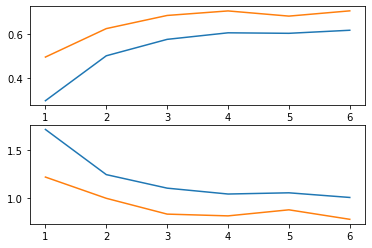

In [93]:
fig = plt.figure()
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
length = len(historyForward.history['acc'])
ax1.plot(range(1,length+1),historyForward.history['acc'])
ax1.plot(range(1,length+1),historyForward.history['val_acc'])
ax2.plot(range(1,length+1),historyForward.history['loss'])
ax2.plot(range(1,length+1),historyForward.history['val_loss'])
plt.show()

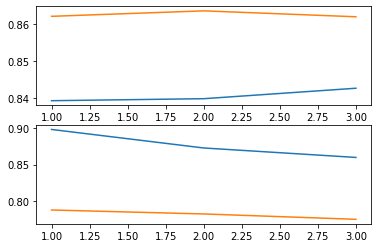

In [94]:
fig = plt.figure()
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
length = len(historyConv.history['acc'])
ax1.plot(range(1,length+1),historyConv.history['acc'])
ax1.plot(range(1,length+1),historyConv.history['val_acc'])
ax2.plot(range(1,length+1),historyConv.history['loss'])
ax2.plot(range(1,length+1),historyConv.history['val_loss'])
plt.show()

In [45]:
labels = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot'
]

In [97]:
loss, acc, cateAcc = simpleForward.evaluate(test_image,test_y)
print(loss,str(acc*100)+"%")

313/313 [==============================] - 0s 776us/step - loss: 0.8042 - acc: 0.7060 - sparse_categorical_accuracy: 0.7060
0.804227352142334 70.59999704360962%


In [98]:
loss, acc, cateAcc, mape, cust = simpleCovnet.evaluate(test_image[...,np.newaxis],test_y)
print(loss,str(acc*100)+"%",mape,cust)

313/313 [==============================] - 1s 3ms/step - loss: 0.7851 - acc: 0.8605 - sparse_categorical_accuracy: 0.8605 - mean_absolute_percentage_error: 10000065.0000 - custom_metric: 4.4210
0.7851336002349854 86.04999780654907% 10000065.0 4.420963764190674


predicted value:
Ankle boot Ankle boot
predicted value:
Shirt Pullover


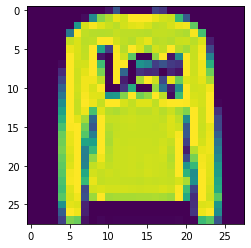

predicted value:
Shirt Trouser


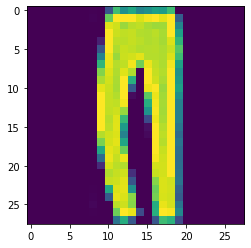

predicted value:
Shirt Trouser


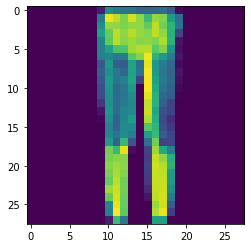

predicted value:
Shirt Shirt
predicted value:
Shirt Trouser


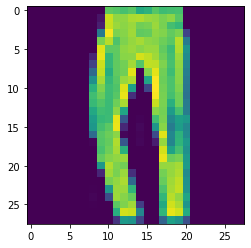

predicted value:
Shirt Coat


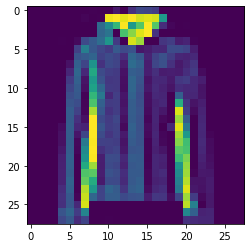

predicted value:
Shirt Shirt
predicted value:
Sandal Sandal
predicted value:
Ankle boot Sneaker


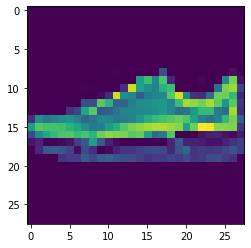

predicted value:
Shirt Coat


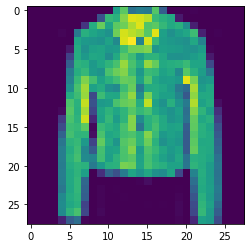

predicted value:
Ankle boot Sandal


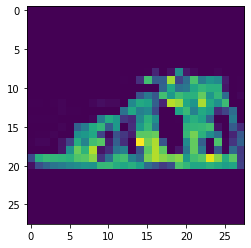

predicted value:
Ankle boot Sneaker


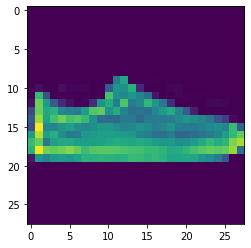

predicted value:
Shirt Dress


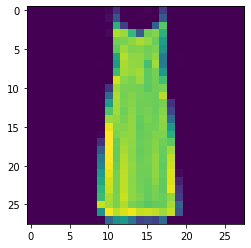

predicted value:
Shirt Coat


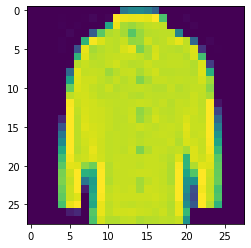

predicted value:
Shirt Trouser


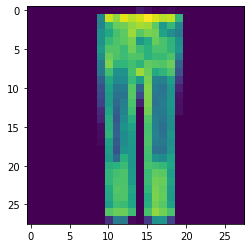

predicted value:
Shirt Pullover


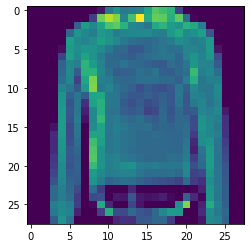

predicted value:
Shirt Coat


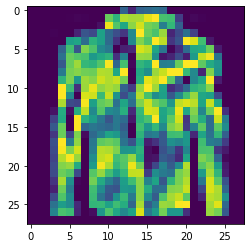

predicted value:
Shirt Bag


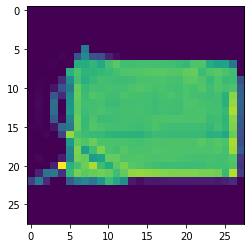

predicted value:
Shirt T-shirt/top


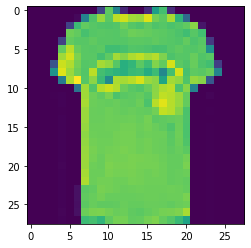

predicted value:
Shirt Pullover


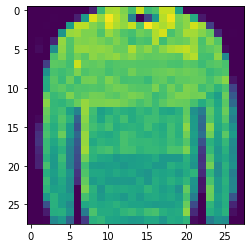

predicted value:
Ankle boot Sandal


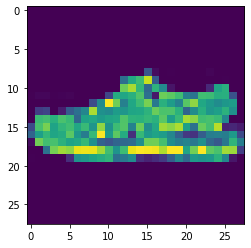

predicted value:
Ankle boot Sneaker


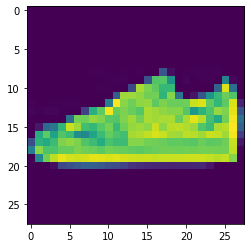

predicted value:
Ankle boot Ankle boot
predicted value:
Shirt Trouser


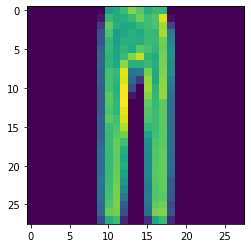

predicted value:
Shirt Coat


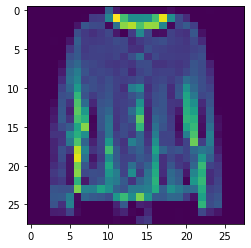

predicted value:
Shirt Shirt
predicted value:
Shirt T-shirt/top


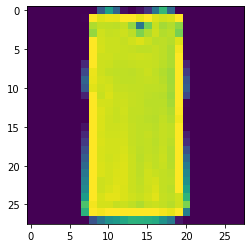

predicted value:
Ankle boot Ankle boot
predicted value:
Shirt Dress


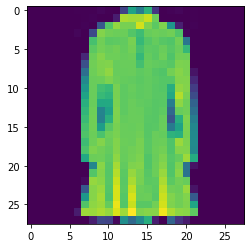

predicted value:
Shirt Bag


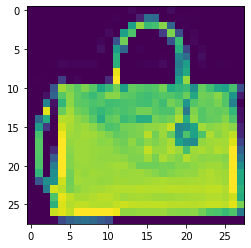

predicted value:
Shirt Bag


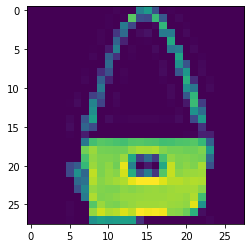

predicted value:
Shirt Dress


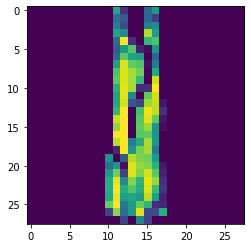

predicted value:
Shirt Dress


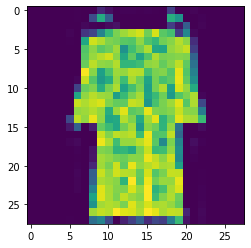

predicted value:
Shirt Bag


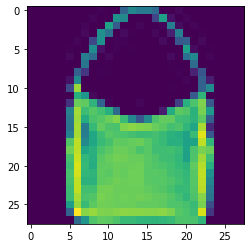

predicted value:
Shirt T-shirt/top


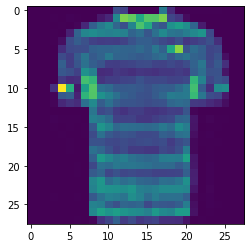

predicted value:
Ankle boot Sneaker


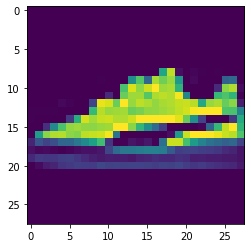

predicted value:
Sandal Sandal
predicted value:
Ankle boot Sneaker


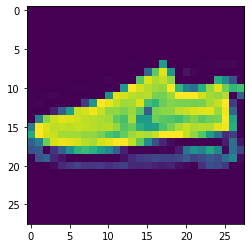

predicted value:
Ankle boot Ankle boot
predicted value:
Shirt Shirt
predicted value:
Shirt Trouser


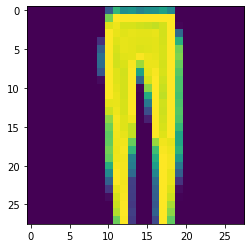

predicted value:
Shirt Dress


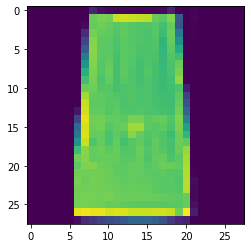

predicted value:
Ankle boot Sneaker


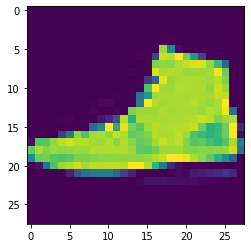

predicted value:
Shirt Shirt
predicted value:
Ankle boot Sneaker


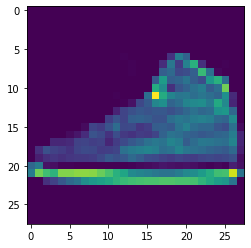

predicted value:
Shirt Pullover


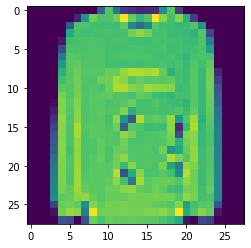

predicted value:
Shirt Trouser


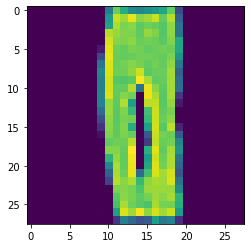

predicted value:
Shirt Pullover


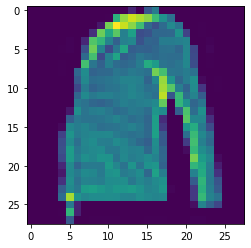

predicted value:
Shirt Pullover


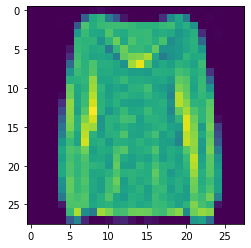

predicted value:
Shirt Coat


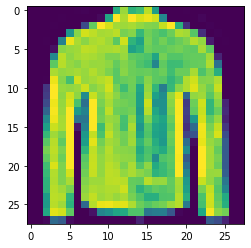

predicted value:
Shirt Coat


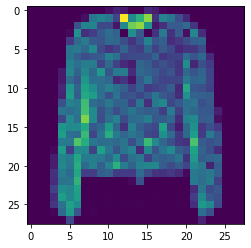

predicted value:
Ankle boot Sandal


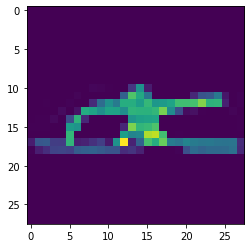

predicted value:
Shirt Bag


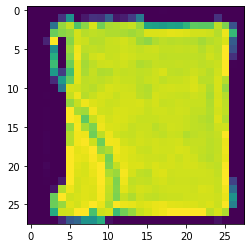

predicted value:
Shirt Pullover


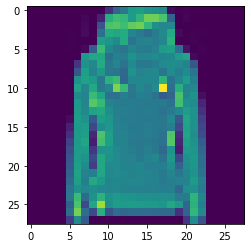

predicted value:
Shirt Pullover


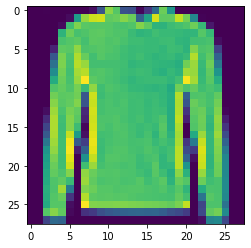

predicted value:
Shirt Bag


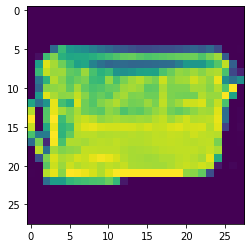

predicted value:
Shirt Coat


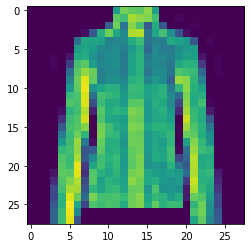

predicted value:
Shirt Bag


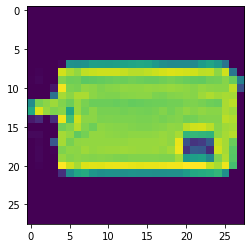

predicted value:
Shirt T-shirt/top


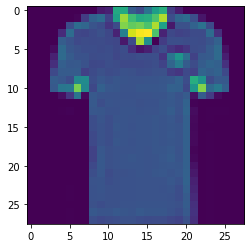

predicted value:
Ankle boot Sneaker


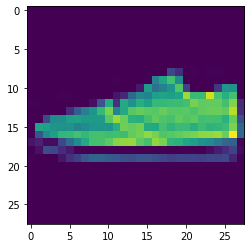

predicted value:
Ankle boot Sneaker


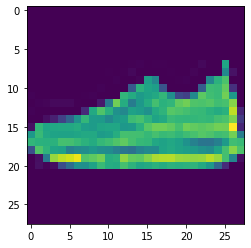

predicted value:
Shirt Bag


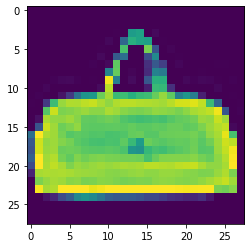

predicted value:
Ankle boot Sandal


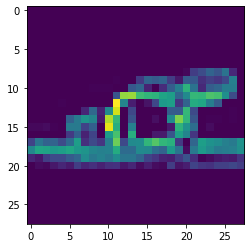

predicted value:
Shirt Trouser


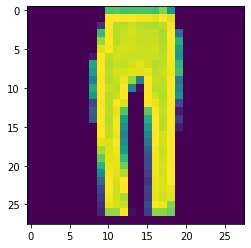

predicted value:
Shirt Trouser


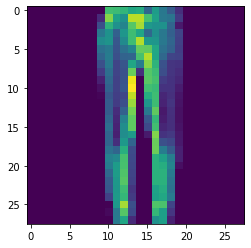

predicted value:
Shirt Pullover


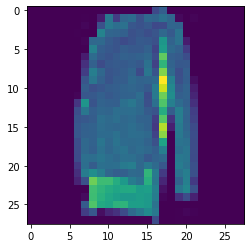

predicted value:
Shirt Dress


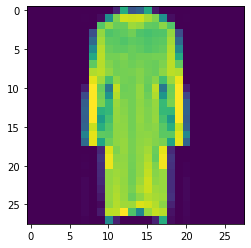

predicted value:
Ankle boot Ankle boot
predicted value:
Shirt Bag


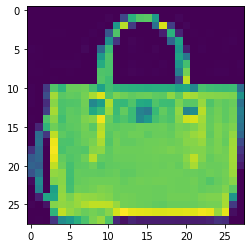

predicted value:
Ankle boot Sneaker


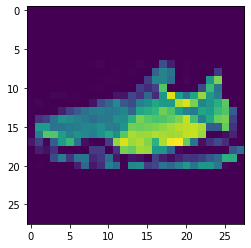

predicted value:
Shirt T-shirt/top


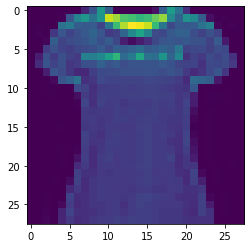

predicted value:
Shirt Pullover


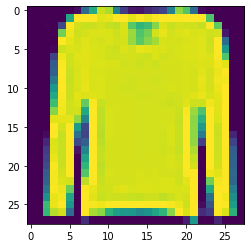

predicted value:
Shirt Shirt
predicted value:
Shirt Pullover


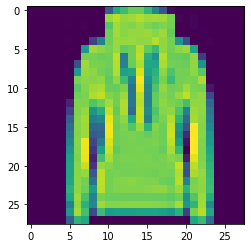

predicted value:
Shirt Dress


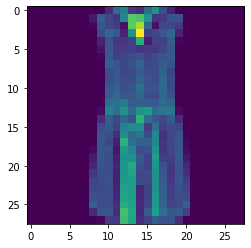

predicted value:
Shirt Trouser


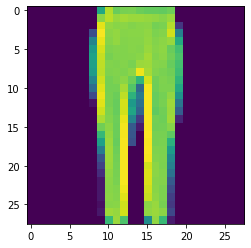

predicted value:
Shirt Pullover


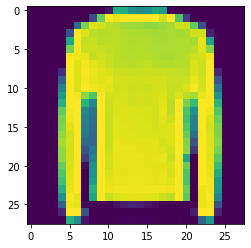

predicted value:
Ankle boot Bag


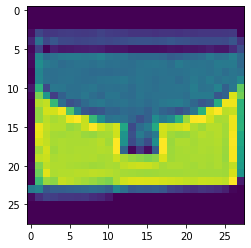

predicted value:
Shirt Coat


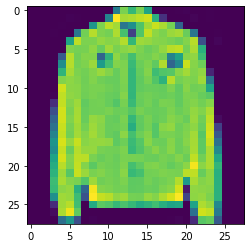

predicted value:
Shirt Trouser


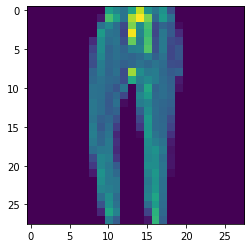

predicted value:
Shirt Bag


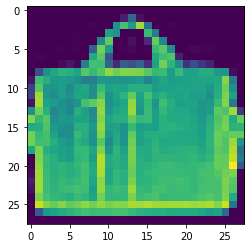

predicted value:
Ankle boot Sandal


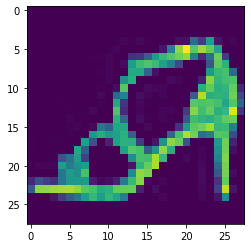

predicted value:
Ankle boot Ankle boot
predicted value:
Ankle boot Sandal


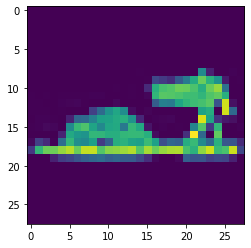

predicted value:
Shirt T-shirt/top


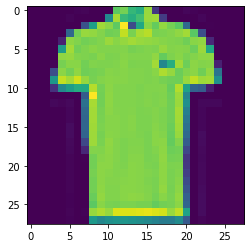

predicted value:
Shirt Dress


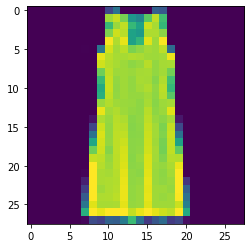

predicted value:
Shirt Pullover


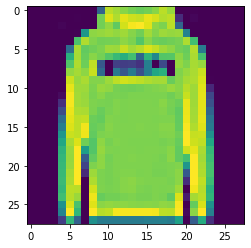

predicted value:
Shirt T-shirt/top


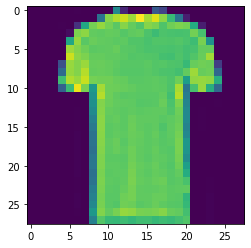

predicted value:
Shirt Shirt
predicted value:
Ankle boot Sandal


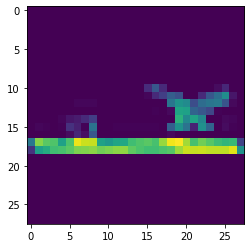

predicted value:
Shirt Dress


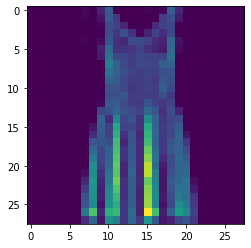

predicted value:
Shirt Shirt
predicted value:
Ankle boot Sneaker


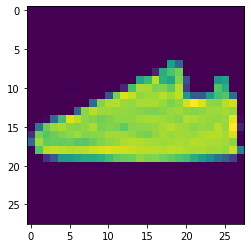

predicted value:
Shirt Trouser


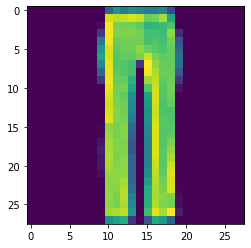

predicted value:
Shirt Bag


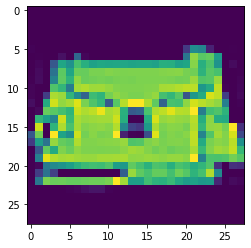

predicted value:
Shirt T-shirt/top


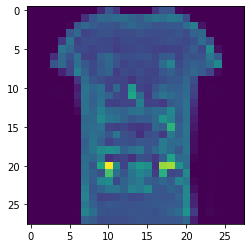

predicted value:
Shirt Trouser


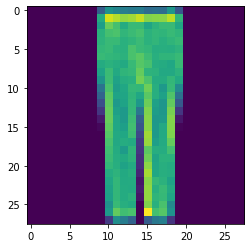

predicted value:
Shirt Coat


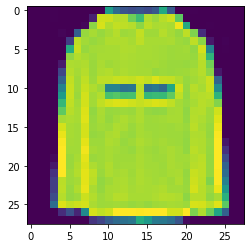

predicted value:
Shirt Pullover


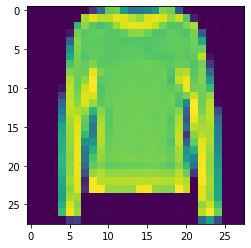

In [48]:
for i in range(100):
    pred = labels[np.argmax(simpleForward.predict(test_image[i][np.newaxis,...],callbacks=[printer()]))]
    actual = labels[test_y[i]]
    print(pred,actual)
    if pred!=actual:
        plt.imshow(test_image[i])
        plt.show()

predicted value:
Ankle boot Ankle boot
predicted value:
Pullover Pullover
predicted value:
Trouser Trouser
predicted value:
Trouser Trouser
predicted value:
Shirt Shirt
predicted value:
Trouser Trouser
predicted value:
Coat Coat
predicted value:
Shirt Shirt
predicted value:
Sandal Sandal
predicted value:
Sneaker Sneaker
predicted value:
Coat Coat
predicted value:
Sandal Sandal
predicted value:
Sandal Sneaker


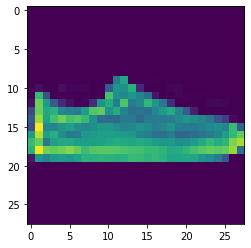

predicted value:
Dress Dress
predicted value:
Coat Coat
predicted value:
Trouser Trouser
predicted value:
Pullover Pullover
predicted value:
Shirt Coat


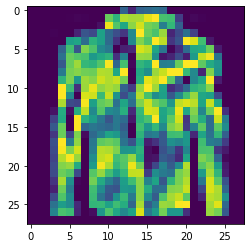

predicted value:
Bag Bag
predicted value:
T-shirt/top T-shirt/top
predicted value:
Pullover Pullover
predicted value:
Sneaker Sandal


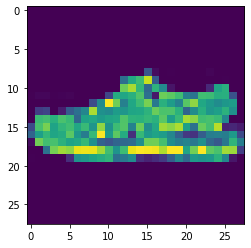

predicted value:
Sneaker Sneaker
predicted value:
Sandal Ankle boot


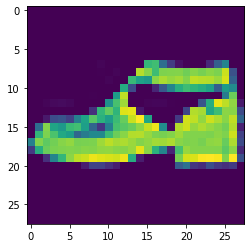

predicted value:
Trouser Trouser
predicted value:
Pullover Coat


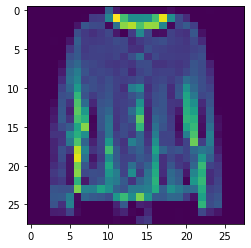

predicted value:
Coat Shirt


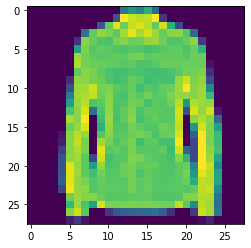

predicted value:
Dress T-shirt/top


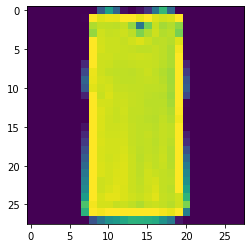

predicted value:
Ankle boot Ankle boot
predicted value:
Dress Dress
predicted value:
Bag Bag
predicted value:
Bag Bag
predicted value:
Dress Dress
predicted value:
Dress Dress
predicted value:
Bag Bag
predicted value:
T-shirt/top T-shirt/top
predicted value:
Sneaker Sneaker
predicted value:
Sandal Sandal
predicted value:
Sneaker Sneaker
predicted value:
Ankle boot Ankle boot
predicted value:
Shirt Shirt
predicted value:
Trouser Trouser
predicted value:
Dress Dress
predicted value:
Sneaker Sneaker
predicted value:
Coat Shirt


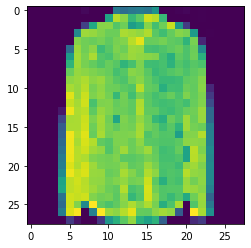

predicted value:
Sneaker Sneaker
predicted value:
Coat Pullover


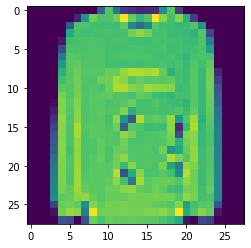

predicted value:
Trouser Trouser
predicted value:
Coat Pullover


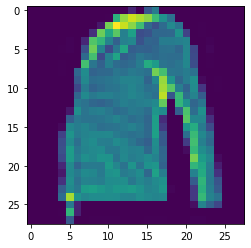

predicted value:
Coat Pullover


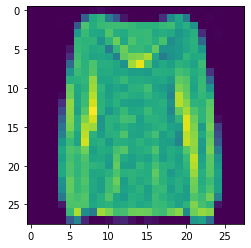

predicted value:
Coat Coat
predicted value:
Coat Coat
predicted value:
Sandal Sandal
predicted value:
Shirt Bag


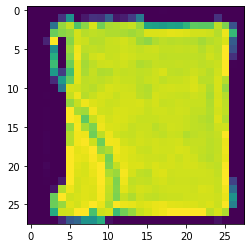

predicted value:
Pullover Pullover
predicted value:
Pullover Pullover
predicted value:
Bag Bag
predicted value:
Coat Coat
predicted value:
Bag Bag
predicted value:
T-shirt/top T-shirt/top
predicted value:
Sneaker Sneaker
predicted value:
Sneaker Sneaker
predicted value:
Bag Bag
predicted value:
Sandal Sandal
predicted value:
Trouser Trouser
predicted value:
Trouser Trouser
predicted value:
Coat Pullover


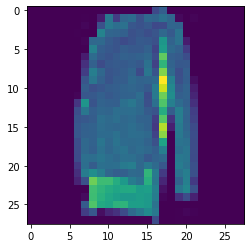

predicted value:
Dress Dress
predicted value:
Sneaker Ankle boot


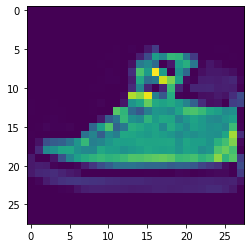

predicted value:
Bag Bag
predicted value:
Sneaker Sneaker
predicted value:
T-shirt/top T-shirt/top
predicted value:
Pullover Pullover
predicted value:
Shirt Shirt
predicted value:
Coat Pullover


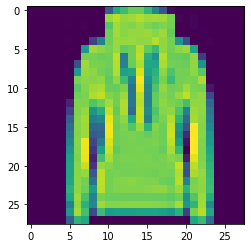

predicted value:
Dress Dress
predicted value:
Trouser Trouser
predicted value:
Pullover Pullover
predicted value:
Bag Bag
predicted value:
Coat Coat
predicted value:
Trouser Trouser
predicted value:
Bag Bag
predicted value:
Sandal Sandal
predicted value:
Ankle boot Ankle boot
predicted value:
Sandal Sandal
predicted value:
T-shirt/top T-shirt/top
predicted value:
Dress Dress
predicted value:
Pullover Pullover
predicted value:
T-shirt/top T-shirt/top
predicted value:
Shirt Shirt
predicted value:
Sandal Sandal
predicted value:
Dress Dress
predicted value:
Shirt Shirt
predicted value:
Sneaker Sneaker
predicted value:
Trouser Trouser
predicted value:
Bag Bag
predicted value:
T-shirt/top T-shirt/top
predicted value:
Trouser Trouser
predicted value:
Coat Coat
predicted value:
Pullover Pullover


In [49]:
for i in range(100):
    pred = labels[np.argmax(simpleCovnet.predict(test_image[i][np.newaxis,...,np.newaxis],callbacks=[printer()]))]
    actual = labels[test_y[i]]
    print(pred,actual)
    if pred!=actual:
        plt.imshow(test_image[i])
        plt.show()

In [99]:
simpleForward.save_weights('tfnative/simpleForward',overwrite=True)
# there are two files to store the weight of a model, tf native as in above or keras h5 file as in below
# tf native method creates 3 files: 
# checkpoint : a metadata storing the location where the weights are stored for to each checkpoint.
# modelName.index : indicates which shard this weight is 
# (when a model is trained on multiple machine, each machine creates one shard, 
# the model is eventually pieced together)
# modelName.data-00000.... is where the weights are (the numerals specify index)
simpleCovnet.save_weights('keras/simpleConv.h5',overwrite=True)

# Model.save_weights only save the weights not the architecture, 
# so only a model with the same architecture can load the weights back in

In [100]:
simpleForward.load_weights('tfnative/simpleForward')
simpleCovnet.load_weights('keras/simpleConv.h5')
# There are only two things to a model, its weights and its architecture. 
# Having both the same means you have the same model.

In [101]:
loss, acc, cateAcc = simpleForward.evaluate(test_image,test_y)
print(loss, acc, cateAcc)
loss, acc, cateAcc, mape, custom = simpleCovnet.evaluate(test_image[...,np.newaxis],test_y)
print(loss, acc, cateAcc)

313/313 [==============================] - 0s 901us/step - loss: 0.8042 - acc: 0.7060 - sparse_categorical_accuracy: 0.7060
0.804227352142334 0.7059999704360962 0.7059999704360962
313/313 [==============================] - 1s 3ms/step - loss: 0.7851 - acc: 0.8605 - sparse_categorical_accuracy: 0.8605 - mean_absolute_percentage_error: 10000065.0000 - custom_metric: 4.4210
0.7851336002349854 0.8604999780654907 0.8604999780654907


In [102]:
simpleForward.save('keras/simpleForwardWholeModel.h5')
simpleCovnet.save('tfnative/simpleConvWholeModel')
# saving the whole model in tf native format creates a new directory with the model name
# inside the directive is assets (what tf needs to run your model), variables (stores weights), 
# and a .pb file which stores information about the graph 

INFO:tensorflow:Assets written to: tfnative/simpleConvWholeModel/assets


In [103]:
from tensorflow.keras.models import load_model

In [114]:
newForwardModel = load_model('keras/simpleForwardWholeModel.h5', compile=True,custom_objects={'lrController':lrController,'printer':printer,'my_init':my_init})
# compile=True means it will automatically compile the model after loading
newConvModel = load_model('tfnative/simpleConvWholeModel',custom_objects={'printer':printer,'custom_metric':custom_metric})
# if we use custom functions or classes and pass them into the model: 
# custom initializer, custom optimizer, custom callbacks, custom activation, custom metrics; 
# then we need to specify the definition of all keywords that are custom functions or classes 
# (we don't need to do for variables, only objects with type not inside tf.keras). 

In [122]:
loss, acc, cateAcc = newForwardModel.evaluate(test_image,test_y)
print(loss, acc, cateAcc)
loss, acc, cateAcc, mape, custom = newConvModel.evaluate(test_image[...,np.newaxis],test_y)
print(loss, acc, cateAcc)

313/313 [==============================] - 0s 952us/step - loss: 0.8042 - acc: 0.1068 - sparse_categorical_accuracy: 0.7060
0.804227352142334 0.10679999738931656 0.7059999704360962
313/313 [==============================] - 1s 3ms/step - loss: 0.7851 - acc: 0.0869 - sparse_categorical_accuracy: 0.8605 - mean_absolute_percentage_error: 10000065.0000 - custom_metric: 4.4210
0.7851336002349854 0.0869000032544136 0.8604999780654907


In [130]:
from tensorflow.keras.models import model_from_config,model_from_yaml,model_from_json
# Sequential().from_config() is preferred to model_from_config() strangely.
# In fact the second may not work.

In [131]:
# We can also get the architecture of the model and perhaps store it somewhere.
# In tensorflow the architecture is called the config
config_dict = newForwardModel.get_config()
print(config_dict)

{'name': 'sequential_2', 'layers': [{'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 28, 28), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'flatten_2_input'}}, {'class_name': 'Flatten', 'config': {'name': 'flatten_2', 'trainable': True, 'batch_input_shape': (None, 28, 28), 'dtype': 'float32', 'data_format': 'channels_last'}}, {'class_name': 'Dense', 'config': {'name': 'layer1', 'trainable': True, 'batch_input_shape': (None, 784), 'dtype': 'float32', 'units': 64, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}, {'class_name': 'Dropout', 'config': {'name': 'dropout_8', 'trainable': True, 'dtype': 'float32', 'rate': 0.4, 'noise_shape': None, 'seed': None}}, {'class_name': 'Dense', 'config'

In [132]:
forwardArchitectureModel = Sequential().from_config(config_dict,custom_objects={'my_init':my_init})
# if it's not sequential, use tensorflow.keras.Model.from_config
# This model should have the same architecture specified in the dictionary 
# but different initialized weights. 
# Since an input_shape is specified, weights will be initialized when we recreate the architecture

In [133]:
# we can also express the model architecture in json or yaml (representation languages)
# These we can save as a file much easier.
jsonString = newConvModel.to_json()
print(jsonString)
yamlString = newConvModel.to_yaml()
print(yamlString)

{"class_name": "Sequential", "config": {"name": "sequential_3", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 28, 28, 1], "dtype": "float32", "sparse": false, "ragged": false, "name": "conv2d_3_input"}}, {"class_name": "Conv2D", "config": {"name": "conv2d_3", "trainable": true, "batch_input_shape": [null, 28, 28, 1], "dtype": "float32", "filters": 16, "kernel_size": [3, 3], "strides": [1, 1], "padding": "valid", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "BatchNormalization", "config": {"name": "batch_normalization_3", "trainable": true, "dtype": "float32", "axis": [3], "momentum": 0.9, "epsilon": 0.

In [135]:
convArchitectureModel = model_from_json(jsonString)
convArchitectureModel = model_from_yaml(yamlString)

In [136]:
# We can import pretrained models from keras.applications or tensorflow hub
from tensorflow.keras.applications import MobileNetV2
# weights downloaded to /keras/models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
# mobilenet is a module, MobileNetV2 is a class
# image class deals with most preprocessing we need for images

In [137]:
mobilenetModel = MobileNetV2(input_shape=(224,224,3), include_top=True, weights='imagenet')
# weights='imagenet' means it will load the weights pretrained by the imagenet dataset
# input_shape=(224,224,3) is conventional since it's the shape of imagenet dataset
# include_top=True means the end classifier layers will be imported, false means only 
# the initial convolutionary (or whatever advanced feature extraction layer they use) will be imported.
# that would be needed if we are doing transfer learning.

14540800/14536120 [==============================] - 1s 0us/step


In [141]:
img = image.load_img('yoda.jpg', target_size=(224,224,3), interpolation='nearest')
img = image.img_to_array(img)
inputImg = preprocess_input(img[np.newaxis,...])
# all those models have their special preprocessing functions, 
# so we must preprocess the image using their specified methods

In [151]:
preds = mobilenetModel.predict(inputImg)
# print(preds)
# pre-decoded preds is just a probability array
preds = decode_predictions(preds,top=3)
# top is the number of top predictions to return
print(preds)

[[1.63853285e-03 5.98928193e-04 3.37092672e-04 1.46005332e-04
  1.16489723e-03 4.22231678e-04 2.32002640e-04 2.31842580e-03
  9.78420139e-04 1.66173503e-02 7.55231420e-04 8.78995284e-04
  5.37971733e-04 6.99447701e-04 3.15316778e-04 8.50568875e-04
  1.07963197e-03 1.14928582e-03 2.80705560e-03 3.83020757e-04
  6.92619069e-04 2.50346813e-04 3.20432754e-03 4.81250323e-03
  1.08462945e-03 3.43000586e-03 4.32038563e-04 9.25348722e-04
  1.36832101e-03 4.29453066e-04 1.01943698e-03 5.59690408e-03
  2.13863198e-02 3.93888942e-04 1.77230497e-04 2.01085000e-03
  3.27618211e-03 8.80507473e-03 8.87731730e-04 1.38145161e-03
  1.87948041e-04 2.12832983e-03 2.79901054e-04 5.23950614e-04
  5.89266827e-04 6.28138136e-04 3.26385692e-04 2.05046101e-03
  6.34071883e-04 1.23758044e-03 5.73478173e-04 3.48930334e-04
  2.43662100e-04 1.31795113e-03 2.17273613e-04 2.12972926e-04
  6.79244913e-05 8.27413227e-04 6.19025144e-04 8.06209224e-04
  8.88599461e-05 7.23201141e-04 4.68847342e-04 9.71920846e-04
  1.5104

In [ ]:
# We can also load models from tensorflow_hub, which is a different module from tensorflow.
# eg:
# import tensorflow_hub as hub
# module_url = "https://tfhub.dev/google/imagenet/mobilenet_v1_050_160/classification/4"
# model = Sequential([hub.KerasLayer(module_url)])
# model.build(input_shape=[None, 160, 160, 3])
# note that the hub.KerasLayer turns a model into a layer
# note also that model.build rebuilds the model after we changed its architecture